### Tutorial in hamiltorch for log probabilities

* For the corresponding blog post please see: https://adamcobb.github.io/journal/hamiltorch.html
* Bayesian neural networks are left to a different notebook 

In [1]:
import torch
import hamiltorch
from hamiltorch.samplers import Integrator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(hamiltorch.__version__)

0.4.1


In [4]:
print(device)

cuda


## Sampling a multivariate Gaussian

In `hamiltorch`, we have designed the samplers to receive a function handle `log_prob_func`, which the sampler will use to evaluate the log probability of each sample. A `log_prob_func` must take a 1-d vector of length equal to the number of parameters that are being sampled. For the example of our multivariate Gaussian distribution, we can define our `log_prob_func` as follows:

In [3]:
def log_prob(omega):
    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.]) 
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

In [4]:
N = 2000
step_size = .3
L = 15

### Sample using standard HMC
* Initialise the parameters e.g. `params_init = torch.zeros(3)` and pass them into the `hamiltorch.sample()` function as `params_init=params_init`.
* Set the number of samples `num_samples=N` corresponding to the number of momentum resampling steps/the number of trajectories to sample.
* Set the step size and trajectory length via `step_size=step_size, num_steps_per_sample=L`.

In [10]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.distributions.Normal(0,1).sample_n(3)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L, burn = 1000)

Sampling (Sampler.HMC; Integrator.IMPLICIT)


/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:19 | 0d:00:00:00 | #################### | 2000/2000 | 101.84       
Acceptance Rate 1.00


### Sample using the No-U-Turn Sampler (NUTS)
* As in Hoffman and Gelman 2011.
* This is set using the additional parameter `sampler=hamiltorch.Sampler.HMC_NUTS`.
* The step size is adapted with the objective of a desired acceptance rate `desired_accept_rate=0.8`.
* The step size is fixed after the burn stage `burn=burn` and we define `N_nuts = burn + N`


In [11]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init =  torch.distributions.Normal(0,1).sample_n(3)
burn=1000
N_nuts = N
params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
                                                  sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
                                                  desired_accept_rate=0.8,)

Sampling (Sampler.HMC; Integrator.IMPLICIT)


/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Invalid log_prob: -inf, params: tensor([-4.2869e+26,  2.2655e+16, -1.6163e+04], requires_grad=True)
Final Adapted Step Size:  0.8532387614250183---- |  993/2000 | 102.93       
0d:00:00:19 | 0d:00:00:00 | #################### | 2000/2000 | 102.08       
Acceptance Rate 0.90


### Sample using the Surrogate HMC Sampler
* As in https://andrewjholbrook.github.io/papers/Li.pdf


In [12]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.distributions.Normal(0,1).sample_n(3)
burn=1000
N_surrogate = N
params_hmc_surrogate, surrogate_model = hamiltorch.sample_surrogate_hmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate,step_size=step_size,num_steps_per_sample=L,burn=burn,
                                                  desired_accept_rate=0.8)

Sampling (Sampler.HMC; Integrator.IMPLICIT)


/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate Model9 | ##########---------- |  999/2000 | 103.18       
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:08 | 0d:00:00:00 | #################### | 1000/1000 | 117.24       
Acceptance Rate 1.00


### Sample using the Surrogate HMC Sampler With Neural Dynamics
* We replace the Hamiltonian and integrator with the Neural ODE

In [14]:
hamiltorch.set_random_seed(123)
params_init = torch.distributions.Normal(0,1).sample_n(3)
burn=1000
N_surrogate_ode = N
params_hmc_surrogate_ode, surrogate_model_ode = hamiltorch.sample_neural_ode_surrogate_hmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate_ode,step_size=step_size,num_steps_per_sample=L,burn=burn,
                                                  )

Sampling (Sampler.HMC; Integrator.IMPLICIT)


/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate ODE Model##########---------- |  989/2000 | 97.05       
0d:00:01:39 | 0d:00:00:00 | #################### | 2000/2000 | 20.05       
Acceptance Rate 0.65


### Sample using the Surrogate HMC Sampler With Neural Dynamics (Explicit hamiltonian )
* We replace the Hamiltonian and integrator with the Neural ODE

In [5]:
hamiltorch.set_random_seed(123)
params_init = torch.distributions.Normal(0,1).sample_n(3)
burn=1000
N_surrogate_ode = N
params_hmc_surrogate_ode_explicit, surrogate_model_ode_explicit = hamiltorch.sample_neural_ode_surrogate_hmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate_ode,step_size=step_size,num_steps_per_sample=L,burn=burn,explicit = True
                                                  )

Sampling (Sampler.HMC; Integrator.IMPLICIT)


/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate ODE Model##########---------- |  992/2000 | 105.95       
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epo

### Sample using implicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* As in Girolami and Calderhead 2011.
* Switch the sampler via setting `sampler=hamiltorch.Sampler.RMHMC` and the integrator via `integrator=hamiltorch.Integrator.IMPLICIT`.
* Limit the number of fixed point iterations in the generalised leapforg via `fixed_point_max_iterations=1000` and set the convergence threshold for 'breaking out' of the while loop via `fixed_point_threshold=1e-05`.


In [6]:
# Implicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_irmhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.IMPLICIT, fixed_point_max_iterations=1000,
                                  fixed_point_threshold=1e-05)

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:08:06 | 0d:00:00:00 | #################### | 2000/2000 | 4.11       
Acceptance Rate 0.99


### Sample using explicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* As in Cobb et. al. 2019
* Switch the integrator to explicit via `integrator=hamiltorch.Integrator.EXPLICIT`. Note that the sampler is still set to RMHMC.
* Introduce and set the binding term via `explicit_binding_const=omega`. This can be subsequently optimised for the highest acceptance rate.



In [7]:
# Explicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
omega = 100.
params_ermhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.EXPLICIT, explicit_binding_const=omega, burn=burn)

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec


### Convert samples to numpy arrays to plot using matplotlib

In [24]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_nuts = torch.cat(params_hmc_nuts).reshape(len(params_hmc_nuts),-1).numpy()
coords_surrogate_ode = torch.cat(params_hmc_surrogate_ode).reshape(len(params_hmc_surrogate_ode),-1).numpy()
coords_surrogate_ode_explicit = torch.cat(params_hmc_surrogate_ode_explicit).reshape(len(params_hmc_surrogate_ode_explicit),-1).numpy()
coords_surrogate = torch.cat(params_hmc_surrogate).reshape(len(params_hmc_surrogate),-1).numpy()
coords_i_rmhmc = torch.cat(params_irmhmc).reshape(len(params_irmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_ermhmc).reshape(len(params_ermhmc),-1).numpy()

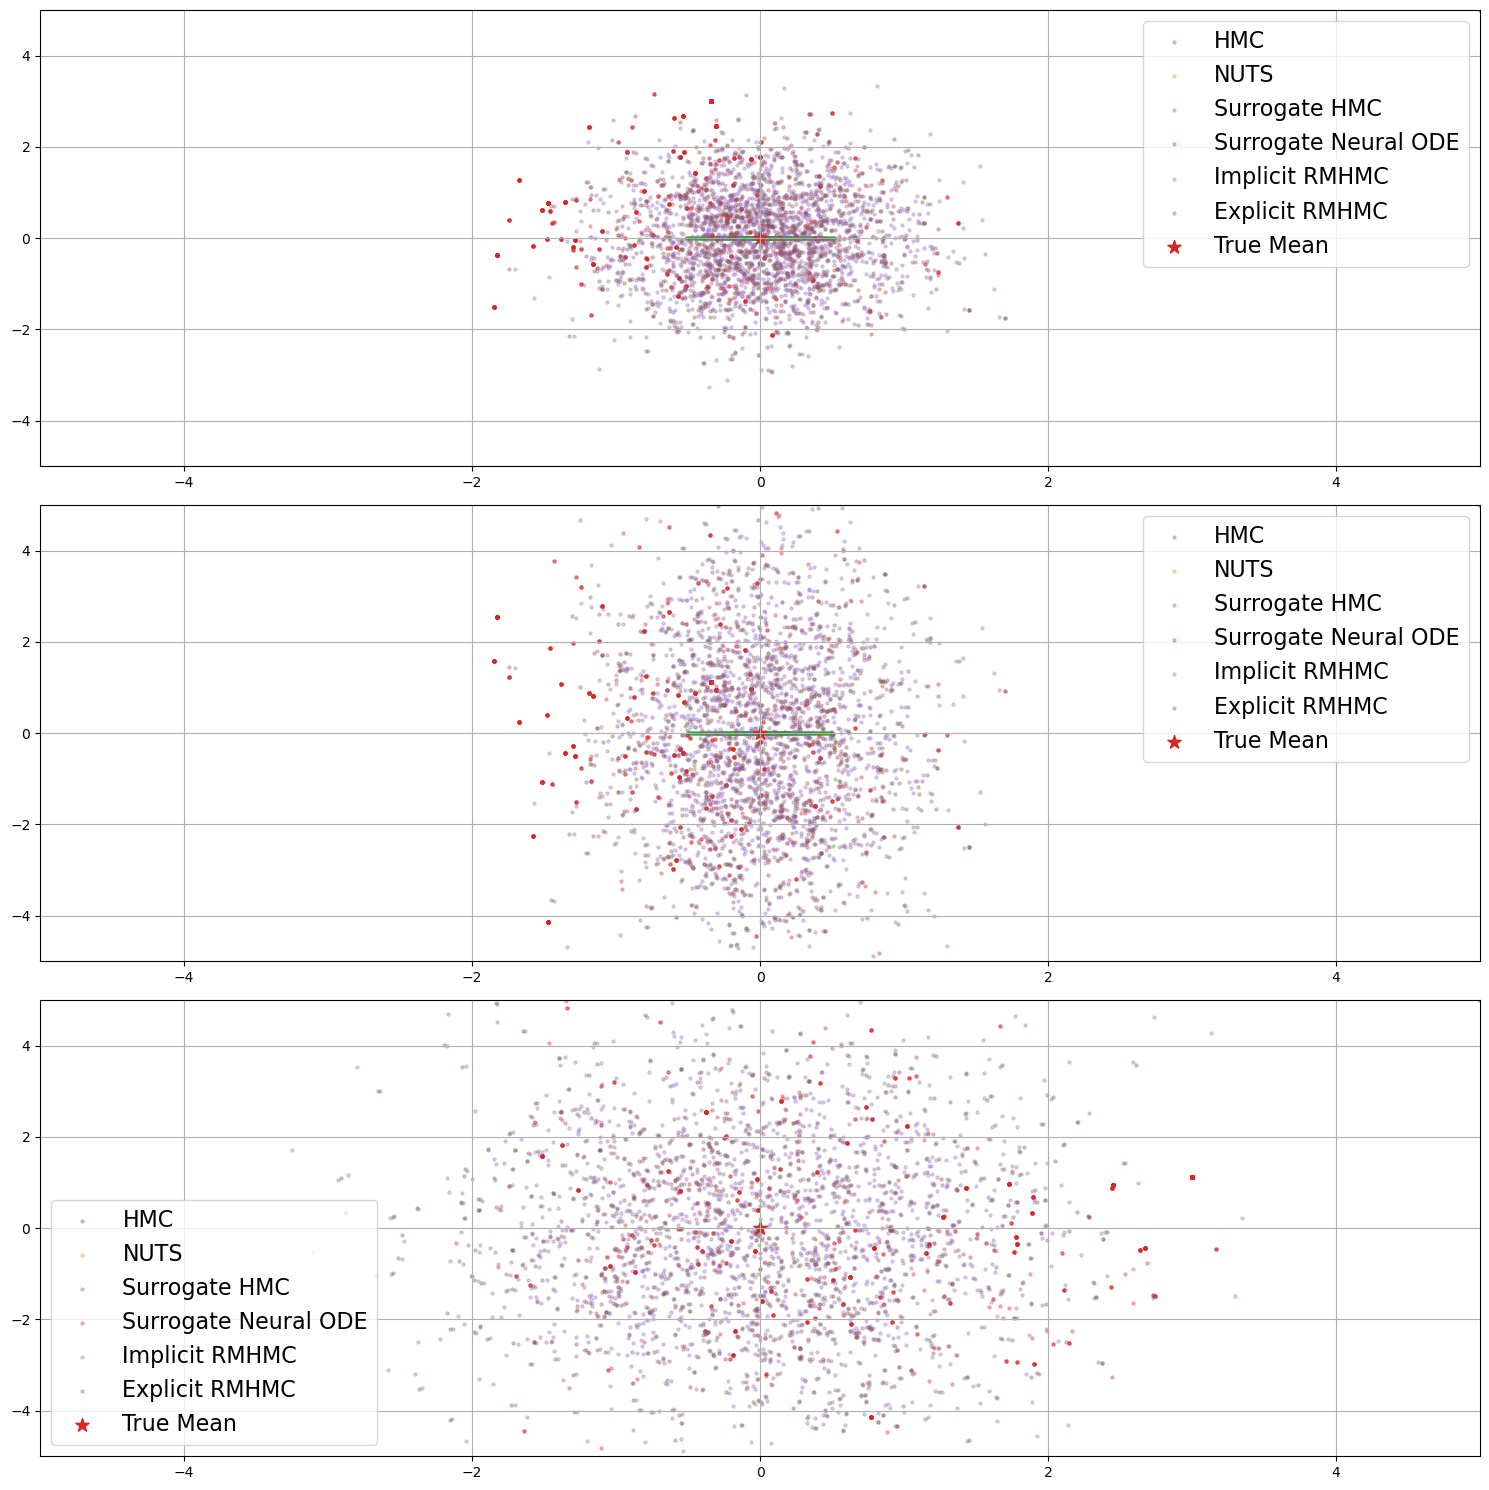

In [26]:
xlim = [-5,5]
ylim = [-5,5]
fs=16
mean = torch.tensor([0.,0.,0.])
stddev = torch.tensor([.5,1.,2.])

fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].scatter(coords_hmc[:,0], coords_hmc[:,1],s=5,alpha=0.3,label='HMC')
axs[0].scatter(coords_nuts[:,0], coords_nuts[:,1],s=5,alpha=0.3,label='NUTS')
axs[0].scatter(coords_surrogate[:,0], coords_surrogate[:,1],s=5,alpha=0.3,label='Surrogate HMC')
axs[0].scatter(coords_surrogate_ode[:,0], coords_surrogate_ode[:,1],s=5,alpha=0.3,label='Surrogate Neural ODE')
axs[0].scatter(coords_surrogate_ode_explicit[:,0], coords_surrogate_ode_explicit[:,1],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit')
axs[0].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,1],s=5,alpha=0.3,label='Implicit RMHMC')
axs[0].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,1],s=5,alpha=0.3,label='Explicit RMHMC')

axs[0].scatter(mean[0],mean[1],marker = '*',color='C3',s=100,label='True Mean')
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].scatter(coords_hmc[:,0], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[1].scatter(coords_nuts[:,0], coords_nuts[:,2],s=5,alpha=0.3,label='NUTS')
axs[1].scatter(coords_surrogate[:,0], coords_surrogate[:,2],s=5,alpha=0.3,label='Surrogate HMC')
axs[1].scatter(coords_surrogate_ode[:,0], coords_surrogate_ode[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE')
axs[1].scatter(coords_surrogate_ode_explicit[:,0], coords_surrogate_ode_explicit[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit')
axs[1].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[1].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[1].scatter(mean[0],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[1].legend(fontsize=fs)
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

axs[2].scatter(coords_hmc[:,1], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[2].scatter(coords_nuts[:,1], coords_nuts[:,2],s=5,alpha=0.3,label='NUTS')
axs[2].scatter(coords_surrogate[:,1], coords_surrogate[:,2],s=5,alpha=0.3,label='Surrogate HMC')
axs[2].scatter(coords_surrogate_ode[:,1], coords_surrogate_ode[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE')
axs[2].scatter(coords_surrogate_ode_explicit[:,1], coords_surrogate_ode_explicit[:,1],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit')

axs[2].scatter(coords_i_rmhmc[:,1], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[2].scatter(coords_e_rmhmc[:,1], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[2].scatter(mean[1],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[2].legend(fontsize=fs)
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.tight_layout()

# plt.savefig('../../Gaussian_plots.png',bbox_inches='tight')
plt.show()

### KL divergence:
* Calculated the KL divergence as a measure of how well we have approximated the target distribution (the Gaussian).

In [27]:
p = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)
q_hmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_hmc.mean(0)),torch.diag(torch.FloatTensor(coords_hmc.var(0))))
q_nuts = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_nuts.mean(0)),torch.diag(torch.FloatTensor(coords_nuts.var(0))))
q_surrogate = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_surrogate.mean(0)),torch.diag(torch.FloatTensor(coords_surrogate.var(0))))
q_surrogate_ode = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_surrogate_ode.mean(0)),torch.diag(torch.FloatTensor(coords_surrogate_ode.var(0))))
q_i_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_i_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_i_rmhmc.var(0))))
q_e_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_e_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_e_rmhmc.var(0))))

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('NUTS kl:           ',torch.distributions.kl.kl_divergence(p, q_nuts))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))
print('Surrogate kl: ',torch.distributions.kl.kl_divergence(p, q_surrogate))
print('Surrogate ODE kl: ',torch.distributions.kl.kl_divergence(p, q_surrogate_ode))

HMC kl:             tensor(98.0726)
NUTS kl:            tensor(98.0715)
Implicit RMHMC kl:  tensor(0.0012)
Explicit RMHMC kl:  tensor(0.0064)
Surrogate kl:  tensor(4220.3853)
Surrogate ODE kl:  tensor(0.7460)


# Sampling from a more complicated distribution: funnel distribution


* This is our new `log_prob_func`.